In [47]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt

from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
from collections import Counter # counter 함수
from sklearn.preprocessing import MinMaxScaler # 스케일링
from functools import reduce # reduce 함수 사용

from tqdm import tqdm_notebook

import pickle

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [81]:
# 모델링 import
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb 
from lightgbm import LGBMClassifier # Classification model

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report # classification report


# cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV # 그리드서치


In [3]:
raw_data = pickle.load( open( "challenge2", "rb" ) ) 
raw_data

CUST_ID  TARGET  BNK_LNIF_CNT  CPT_LNIF_CNT  SPART_LNIF_CNT  \
0             1       0             1             0               0   
1             2       0             1             0               0   
2             3       0             0             1               3   
3             4       1             0             2               4   
4             5       0             4             0               0   
5             6       0             1             0               1   
6             7       0             0             1               2   
7             8       0             1             0               0   
8             9       0             2             0               0   
9            10       0             0             1               1   
10           11       1             0             3               5   
11           12       0             0             1               2   
12           13       0             1             0               0   
13           14       0             2             0               0   
14           15       0             3             1               1   
15           16       0             1             0               1   
16           17       0             1             0               3   
17           18       0             1             0               0   
18           19       0             1             0               0   
19           20       0             2             0               1   
20           21       0             0             0               1   
21           22       0             0             0               1   
22           23       0             0             0               1   
23           24       0             0             1               2   
24           25       0             1             0               0   
25           26       0             1             0               0   
26           27       0             0             0               1   
27           28       0             1             0               0   
28           29       0             3             0               0   
29           30       0             0             0               1   
30           31       0             1             0               0   
31           32       0             4             0               2   
32           33       0             0             0               1   
33           34       0             0             0               1   
34           35       0             1             0               0   
35           36       0             1             0               0   
36           37       1             0             1               2   
37           38       0             2             0               0   
38           39       0             0             1               2   
39           40       0             1             1               1   
40           41       0             0             0               1   
41           42       0             0             2               2   
42           43       0             0             1               2   
43           44       0             1             0               0   
44           45       0             1             1               3   
45           46       0             0             1               1   
46           47       1             0             1               2   
47           48       0             1             4               4   
48           49       0             0             0               2   
49           50       0             2             0               1   
50           51       0             1             0               1   
51           52       0             1             2               2   
52           53       0             1             0               1   
53           54       0             1             0               1   
54           55       0             0             2               2   
55           56       0         

In [4]:
# 전체 데이터, 상환, 부실 데이터 개수 및 비율 확인 함수

def check_prop ( checking_data):
    label_1 = len(checking_data.loc[checking_data['TARGET'] == 1])
    label_0 = len(checking_data.loc[checking_data['TARGET'] == 0])
    label_prop = label_1 / (label_1 + label_0)

    print (" 1) 전체 데이터 개수 : {} \n 2) 상환 개수 : {} \n 3) 부실 개수: {} \n 4) 부실데이터 비율: {:.2f} ".\
           format( label_1+label_0, label_0, label_1, label_prop))


In [5]:
check_prop(raw_data)

 1) 전체 데이터 개수 : 100233 
 2) 상환 개수 : 95946 
 3) 부실 개수: 4287 
 4) 부실데이터 비율: 0.04 


In [6]:
# CUST_ID 삭제 (index와 값이 같음), X와 y 나눔
X = raw_data.drop(['CUST_ID', 'TARGET'], axis=1)
y = raw_data['TARGET']



# SMOTE적용 전 스케일링
* minmaxscaler

In [7]:


scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)


# smote적용 전 모델링 


* X_scaled, y


In [8]:

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=42)
forest = RandomForestClassifier (n_estimators=5, random_state=2)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

print ("훈련세트 정확도: {:.3f}". format(forest.score(X_train, y_train)))
print ("테스트 세트 정확도: {:.3f}".format(forest.score(X_test, y_test)))

훈련세트 정확도: 0.993
테스트 세트 정확도: 0.955


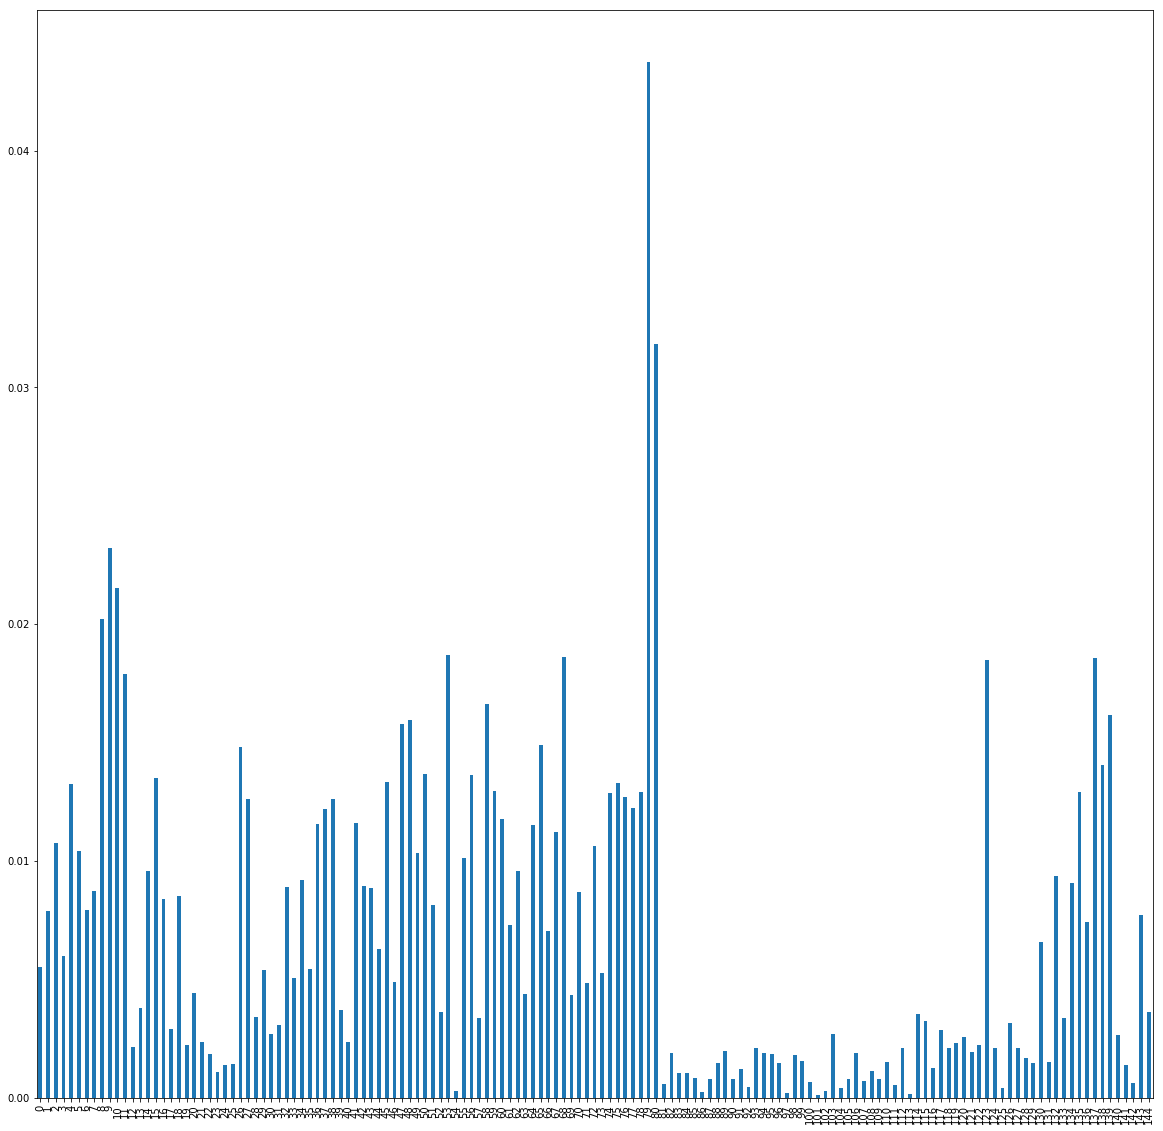

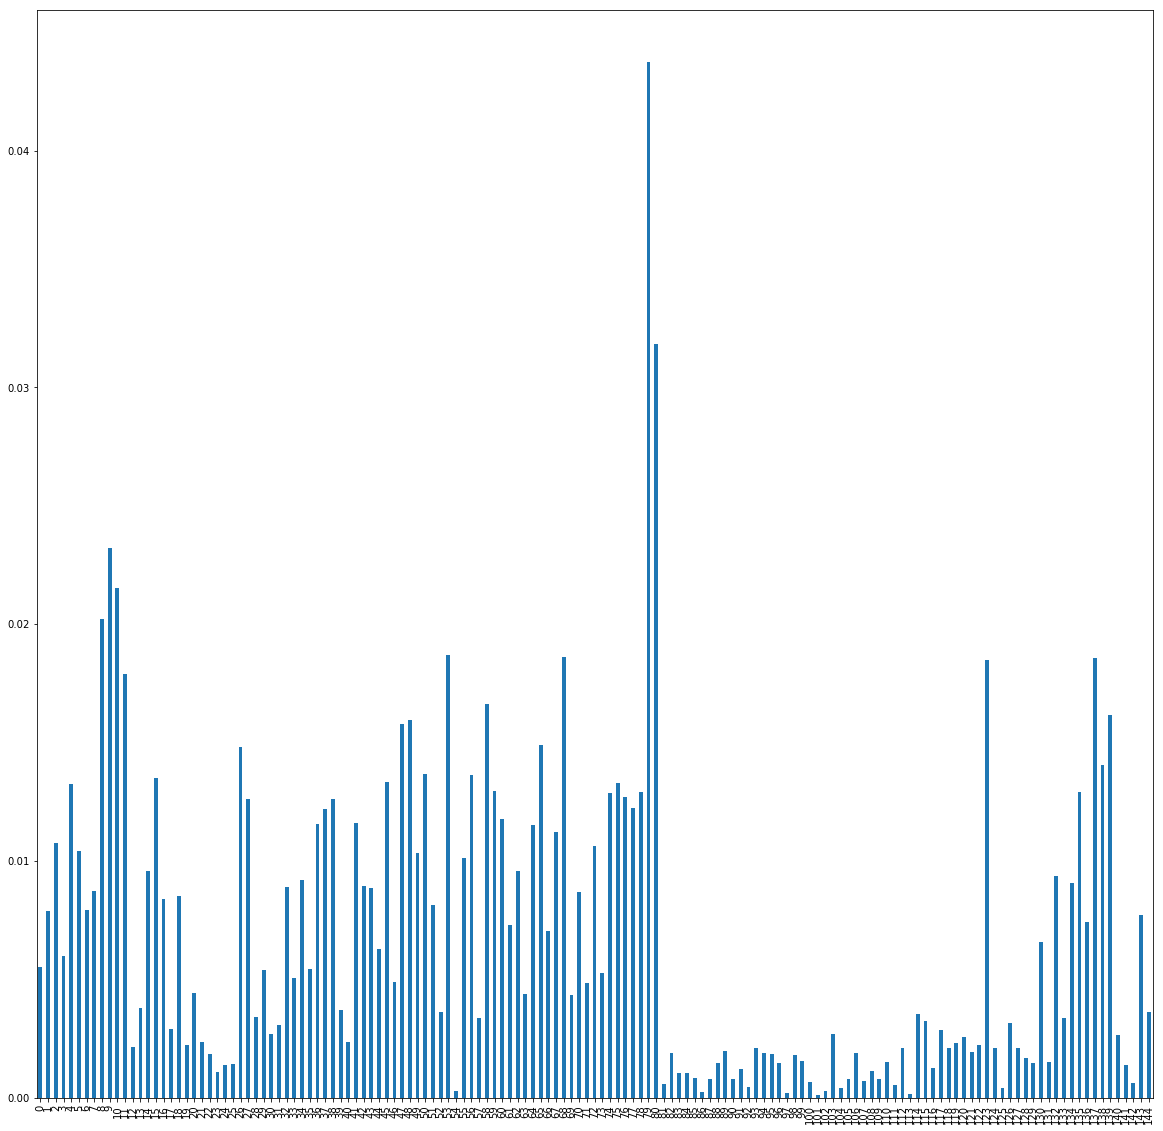

In [18]:
# 중요한 변수
importances = forest.feature_importances_
plt.figure(figsize=(20,20))
pd.Series(importances, index=pd.DataFrame(X_scaled).columns). plot(kind='bar')
plt.show()

In [20]:

f1_score(y_test, y_pred)

0.2543046357615894

#### 확실히 오버샘플링을 적용하지 않으면 f1스코어는 형편없이 나옴을 알 수 있다 

# borderSMOTE 적용
* borderline1


In [21]:
X_resampled, y_resampled = SMOTE(kind='borderline1').fit_sample(X_scaled,y)



In [22]:
y_resampled = pd.DataFrame(y_resampled).rename(columns={0:'TARGET'})
# y값의 변수 이름 변환

X_resampled = pd.DataFrame(X_resampled)

temp = pd.concat([y_resampled, X_resampled], axis=1) 
# 비율을 확인하기 위해 잠시 합함

In [23]:
check_prop(temp)

 1) 전체 데이터 개수 : 191892 
 2) 상환 개수 : 95946 
 3) 부실 개수: 95946 
 4) 부실데이터 비율: 0.50 


In [24]:
X_resampled.columns = X.columns

# 군집분석


### k-means

print ("클러스터 레이블: \n {}". format(kmeans.labels_))

### 평가방법: Elbow method


In [12]:


elbow_scores = [] # 엘보우 점수

iterations = range(1, 30)

for i in tqdm_notebook(iterations): # 클러스터를 1~10 까지 대입해보며 점수 저장
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(X_resampled)
    #cluster_labels = kmeans.fit_predict(X_resampled)
    
    es = kmeans.score(X_resampled)
    elbow_scores.append(es)
    
    #ss = silhouette_score(X_resampled, cluster_labels)
    #silhouette_scores.append(ss)
    
    

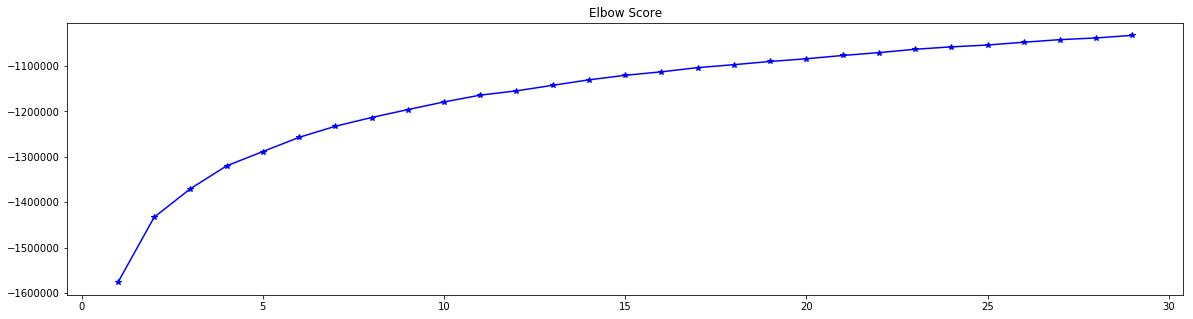

In [14]:

%matplotlib inline

plt.figure(figsize = (20, 5))
plt.plot(iterations, elbow_scores, 'b*-')
plt.title ('Elbow Score')

* 중복된 변수를 제거 하지 않아서인지 급격히 감소하는 지점이 없어 보인다
* 일단 4개로 해 보자

### cluster : 4개

In [25]:
kmeans = KMeans(n_clusters = 4)
kmeans.fit(X_resampled)
print ("클러스터 레이블: \n {}". format(kmeans.labels_))

클러스터 레이블: 
 [2 2 1 ..., 0 3 1]


In [26]:
prediction = kmeans.predict(X_resampled)
prediction = pd.DataFrame(prediction)
prediction.rename(columns={0:'CLUSTER'}, inplace=True)


In [27]:
X_resampled_cluster = X_resampled.values
print ("데이터 타입은 : {}".format(X_resampled_cluster.dtype))
print (X_resampled_cluster)
    

데이터 타입은 : float64
[[ 0.2         0.          0.         ...,  0.          0.1         0.        ]
 [ 0.2         0.          0.         ...,  0.          0.1         0.        ]
 [ 0.          0.2         0.42857143 ...,  0.          0.1         0.        ]
 ..., 
 [ 0.2         0.4         0.42857143 ...,  0.          0.07755594  0.        ]
 [ 0.23531454  0.27062908  0.31093896 ...,  0.          0.41171365  0.        ]
 [ 0.026243    0.226243    0.29508678 ...,  0.          0.1131215   0.9       ]]


In [28]:
pd.DataFrame(X_resampled_cluster).head()

0    1         2         3         4         5         6        7    \
0  0.2  0.0  0.000000  0.000000  0.009054  0.009055  0.009535  0.00000   
1  0.2  0.0  0.000000  0.000000  0.024145  0.000000  0.025425  0.00000   
2  0.0  0.2  0.428571  0.333333  0.015091  0.009055  0.000000  0.00997   
3  0.0  0.4  0.571429  0.333333  0.006036  0.003019  0.000000  0.00997   
4  0.8  0.0  0.000000  0.000000  0.021127  0.015092  0.022247  0.00000   

        8         9         10        11   12        13    14     15   \
0  0.008264  0.000000  0.181818  0.107438  0.3  0.428572  0.54  0.385   
1  0.000000  0.000000  0.181818  1.000000  0.0  0.000000  0.55  0.405   
2  0.008264  0.206612  0.363636  1.000000  0.0  0.000000  0.00  0.245   
3  0.008264  0.206612  0.363636  0.504132  0.0  0.000000  0.00  0.505   
4  0.008264  0.000000  0.090909  0.801653  0.0  0.000000  0.48  0.240   

        16    17   18   19   20   21   22   23   24   25    26        27   \
0  0.428571  0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.12  0.222222   
1  0.428571  0.25  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.13  0.000000   
2  0.428571  0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.02  0.000000   
3  0.142857  0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.04  0.000000   
4  0.428571  0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.00  0.000000   

    28        29   30   31      32   33      34   35     36     37     38   \
0  0.00  0.000000  0.0  0.0  0.0475  0.0  0.0475  0.0  0.019  0.020  0.020   
1  0.00  0.000000  0.0  0.0  0.0000  0.0  0.0275  0.0  0.000  0.007  0.036   
2  0.00  0.000000  0.0  0.0  0.0000  0.0  0.0000  0.0  0.010  0.011  0.011   
3  0.00  0.000000  0.0  0.0  0.0000  0.0  0.0000  0.0  0.000  0.004  0.004   
4  0.95  0.019802  0.0  0.0  0.0000  0.0  0.0000  0.0  0.030  0.004  0.004   

   39   40        41        42        43        44   45   46      47   \
0  0.0  0.0  0.163934  0.000000  0.000000  0.000000  0.6  0.0  0.0450   
1  0.0  0.0  0.000000  0.001000  0.011696  0.227273  0.6  0.0  0.0081   
2  0.0  0.0  0.000000  0.000000  0.000000  0.090909  0.8  1.0  0.0139   
3  0.0  0.0  0.000000  0.000000  0.000000  0.045455  0.3  0.0  0.1118   
4  0.0  0.0  0.000000  0.001666  0.011696  0.045455  0.5  0.0  0.0396   

        48        49        50        51   52        53   54       55   \
0  0.259474  0.060002  0.084211  0.666667  0.0  0.000000  0.0  0.00000   
1  0.011579  0.060002  0.042105  0.416667  0.0  0.000000  0.0  0.00000   
2  0.008947  0.060002  0.042105  0.416667  0.0  0.000000  0.0  0.00000   
3  0.000000  0.060002  0.084211  0.750000  0.0  0.450000  0.0  0.39375   
4  0.186316  0.100002  0.084211  0.666667  0.0  0.108333  0.0  0.05625   

        56   57        58        59        60        61        62        63   \
0  0.527273  0.0  0.233333  0.659311  0.772923  0.774854  0.000000  0.959074   
1  0.081818  0.0  0.077778  0.730337  0.000000  0.822312  0.000000  0.000000   
2  0.109091  0.0  0.255556  0.696301  0.772923  0.000000  0.763958  0.000000   
3  0.290909  0.0  0.066667  0.629952  0.719905  0.000000  0.763958  0.000000   
4  0.372727  0.0  0.144444  0.720667  0.797578  0.815851  0.000000  0.000000   

        64        65   66        67        68        69        70   71   \
0  0.966549  0.950062  0.0  0.785607  0.953990  0.000000  0.799562  0.0   
1  0.967545  0.952711  0.0  0.785607  0.820050  0.000000  0.000000  0.0   
2  0.000000  0.926415  0.0  0.785607  0.840731  0.000000  0.000000  0.0   
3  0.000000  0.964256  0.0  0.785607  0.911239  0.000000  0.000000  0.0   
4  0.960155  0.925336  0.0  0.824532  0.929055  0.787204  0.000000  0.0   

        72   73        74        75        76        77        78        79   \
0  0.799562  0.0  0.754108  0.811226  0.811226  0.820228  0.000000  0.000000   
1  0.763610  0.0  0.000000  0.760566  0.839589  0.769870  0.000000  0.000000   
2  0.000000  0.0  0.714286  0.782377  0.782377  0.769870  0.000000  0.000000   
3  0.000000  0.0  0.000000  0.733562  0.733562  0.8

In [29]:
cluster_4 = pd.concat([prediction, pd.DataFrame(X_resampled_cluster)], axis=1)

In [30]:
cluster_4

CLUSTER         0         1         2         3         4  \
0             2  0.200000  0.000000  0.000000  0.000000  0.009054   
1             2  0.200000  0.000000  0.000000  0.000000  0.024145   
2             1  0.000000  0.200000  0.428571  0.333333  0.015091   
3             0  0.000000  0.400000  0.571429  0.333333  0.006036   
4             2  0.800000  0.000000  0.000000  0.000000  0.021127   
5             2  0.200000  0.000000  0.142857  0.166667  0.141851   
6             1  0.000000  0.200000  0.285714  0.166667  0.012072   
7             2  0.200000  0.000000  0.000000  0.000000  0.003018   
8             1  0.400000  0.000000  0.000000  0.000000  0.274648   
9             2  0.000000  0.200000  0.142857  0.000000  0.009054   
10            1  0.000000  0.600000  0.714286  0.333333  0.027163   
11            2  0.000000  0.200000  0.285714  0.166667  0.009054   
12            3  0.200000  0.000000  0.000000  0.000000  0.012072   
13            0  0.400000  0.000000  0.000000  0.000000  0.202213   
14            3  0.600000  0.200000  0.142857  0.000000  0.015091   
15            2  0.200000  0.000000  0.142857  0.166667  0.341046   
16            1  0.200000  0.000000  0.428571  0.500000  0.039235   
17            3  0.200000  0.000000  0.000000  0.000000  0.274648   
18            1  0.200000  0.000000  0.000000  0.000000  0.018109   
19            1  0.400000  0.000000  0.142857  0.166667  0.175050   
20            0  0.000000  0.000000  0.142857  0.166667  0.165996   
21            3  0.000000  0.000000  0.142857  0.166667  0.108652   
22            2  0.000000  0.000000  0.142857  0.166667  0.181087   
23            0  0.000000  0.200000  0.285714  0.166667  0.051308   
24            2  0.200000  0.000000  0.000000  0.000000  0.193159   
25            3  0.200000  0.000000  0.000000  0.000000  0.027163   
26            1  0.000000  0.000000  0.142857  0.166667  0.006036   
27            2  0.200000  0.000000  0.000000  0.000000  0.039235   
28            3  0.600000  0.000000  0.000000  0.000000  0.316901   
29            0  0.000000  0.000000  0.142857  0.166667  0.003018   
30            1  0.200000  0.000000  0.000000  0.000000  0.009054   
31            2  0.800000  0.000000  0.285714  0.500000  0.413481   
32            2  0.000000  0.000000  0.142857  0.166667  0.093561   
33            1  0.000000  0.000000  0.142857  0.166667  0.006036   
34            2  0.200000  0.000000  0.000000  0.000000  0.199195   
35            3  0.200000  0.000000  0.000000  0.000000  0.054326   
36            0  0.000000  0.200000  0.285714  0.166667  0.003018   
37            2  0.400000  0.000000  0.000000  0.000000  0.069416   
38            1  0.000000  0.200000  0.285714  0.166667  0.247485   
39            1  0.200000  0.200000  0.142857  0.000000  0.096579   
40            0  0.000000  0.000000  0.142857  0.166667  0.087525   
41            1  0.000000  0.400000  0.285714  0.000000  0.018109   
42            2  0.000000  0.200000  0.285714  0.166667  0.012072   
43            3  0.200000  0.000000  0.000000  0.000000  0.003018   
44            2  0.200000  0.200000  0.428571  0.333333  0.006036   
45            0  0.000000  0.200000  0.142857  0.000000  0.036217   
46            3  0.000000  0.200000  0.285714  0.166667  0.003018   
47            3  0.200000  0.800000  0.571429  0.000000  0.030181   
48            1  0.000000  0.000000  0.285714  0.333333  0.024145   
49            3  0.400000  0.000000  0.142857  0.166667  1.000000   
50            3  0.200000  0.000000  0.142857  0.166667  0.084507   
51            2  0.200000  0.400000  0.285714  0.000000  0.301811   
52            0  0.200000  0.000000  0.142857  0.166667  0.265594   
53            0  0.200000  0.000000  0.142857  0.166667  0.003018   
54            1  0.000000  0.400000  0.285714  0.000000  0.009054   
55            1  0.200000  0.400000  0.285714  0.000000  0.018109   
56            2  0.200000  0.000000  0.000000  0.000000  0.051308   
57    

### 각 클러스터 별로 데이터의 비율 확인

In [31]:
cluster_4 = pd.concat([y_resampled, cluster_4],axis=1)
cluster_4

TARGET  CLUSTER         0         1         2         3         4  \
0            0        2  0.200000  0.000000  0.000000  0.000000  0.009054   
1            0        2  0.200000  0.000000  0.000000  0.000000  0.024145   
2            0        1  0.000000  0.200000  0.428571  0.333333  0.015091   
3            1        0  0.000000  0.400000  0.571429  0.333333  0.006036   
4            0        2  0.800000  0.000000  0.000000  0.000000  0.021127   
5            0        2  0.200000  0.000000  0.142857  0.166667  0.141851   
6            0        1  0.000000  0.200000  0.285714  0.166667  0.012072   
7            0        2  0.200000  0.000000  0.000000  0.000000  0.003018   
8            0        1  0.400000  0.000000  0.000000  0.000000  0.274648   
9            0        2  0.000000  0.200000  0.142857  0.000000  0.009054   
10           1        1  0.000000  0.600000  0.714286  0.333333  0.027163   
11           0        2  0.000000  0.200000  0.285714  0.166667  0.009054   
12           0        3  0.200000  0.000000  0.000000  0.000000  0.012072   
13           0        0  0.400000  0.000000  0.000000  0.000000  0.202213   
14           0        3  0.600000  0.200000  0.142857  0.000000  0.015091   
15           0        2  0.200000  0.000000  0.142857  0.166667  0.341046   
16           0        1  0.200000  0.000000  0.428571  0.500000  0.039235   
17           0        3  0.200000  0.000000  0.000000  0.000000  0.274648   
18           0        1  0.200000  0.000000  0.000000  0.000000  0.018109   
19           0        1  0.400000  0.000000  0.142857  0.166667  0.175050   
20           0        0  0.000000  0.000000  0.142857  0.166667  0.165996   
21           0        3  0.000000  0.000000  0.142857  0.166667  0.108652   
22           0        2  0.000000  0.000000  0.142857  0.166667  0.181087   
23           0        0  0.000000  0.200000  0.285714  0.166667  0.051308   
24           0        2  0.200000  0.000000  0.000000  0.000000  0.193159   
25           0        3  0.200000  0.000000  0.000000  0.000000  0.027163   
26           0        1  0.000000  0.000000  0.142857  0.166667  0.006036   
27           0        2  0.200000  0.000000  0.000000  0.000000  0.039235   
28           0        3  0.600000  0.000000  0.000000  0.000000  0.316901   
29           0        0  0.000000  0.000000  0.142857  0.166667  0.003018   
30           0        1  0.200000  0.000000  0.000000  0.000000  0.009054   
31           0        2  0.800000  0.000000  0.285714  0.500000  0.413481   
32           0        2  0.000000  0.000000  0.142857  0.166667  0.093561   
33           0        1  0.000000  0.000000  0.142857  0.166667  0.006036   
34           0        2  0.200000  0.000000  0.000000  0.000000  0.199195   
35           0        3  0.200000  0.000000  0.000000  0.000000  0.054326   
36           1        0  0.000000  0.200000  0.285714  0.166667  0.003018   
37           0        2  0.400000  0.000000  0.000000  0.000000  0.069416   
38           0        1  0.000000  0.200000  0.285714  0.166667  0.247485   
39           0        1  0.200000  0.200000  0.142857  0.000000  0.096579   
40           0        0  0.000000  0.000000  0.142857  0.166667  0.087525   
41           0        1  0.000000  0.400000  0.285714  0.000000  0.018109   
42           0        2  0.000000  0.200000  0.285714  0.166667  0.012072   
43           0        3  0.200000  0.000000  0.000000  0.000000  0.003018   
44           0        2  0.200000  0.200000  0.428571  0.333333  0.006036   
45           0        0  0.000000  0.200000  0.142857  0.000000  0.036217   
46           1        3  0.000000  0.200000  0.285714  0.166667  0.003018   
47           0        3  0.200000  0.800000  0.571429  0.000000  0.030181   
48           0        1  0.000000  0.000000  0.285714  0.333333  0.024145   
49           0        3  0.400000  0.000000  0.142857  0.166667  1.000000   
50           0        3  0.200000  0.000000  0.142857  0.166667  0.084507   
51  

In [32]:
# 클러스터값이 같은 데이터끼리 하나로 묶음

columns_val_name = ["cluster_4_{}".format (i) for i in range(0, 5) ]
columns_list = []

for i in range(0, 5):
    columns_list.append(pd.DataFrame(cluster_4.loc[cluster_4.CLUSTER == i]))

In [33]:
# 각 클러스터 별로 데이터의 비율을 확인

for i in range(0,4):
    print (columns_val_name[i])
    check_prop(pd.DataFrame(columns_list[i]))



cluster_4_0
 1) 전체 데이터 개수 : 45364 
 2) 상환 개수 : 20190 
 3) 부실 개수: 25174 
 4) 부실데이터 비율: 0.55 
cluster_4_1
 1) 전체 데이터 개수 : 50066 
 2) 상환 개수 : 27278 
 3) 부실 개수: 22788 
 4) 부실데이터 비율: 0.46 
cluster_4_2
 1) 전체 데이터 개수 : 40389 
 2) 상환 개수 : 23438 
 3) 부실 개수: 16951 
 4) 부실데이터 비율: 0.42 
cluster_4_3
 1) 전체 데이터 개수 : 56073 
 2) 상환 개수 : 25040 
 3) 부실 개수: 31033 
 4) 부실데이터 비율: 0.55 


# 모델 적용

## Random Forest

In [107]:


#X_0 = columns_list[2].drop(['TARGET', 'CLUSTER'], axis=1) # 첫번째 클러스터의 X, y 를 나눔
#y_0 = columns_list[2]['TARGET']

X_0 = X_resampled # 클러스터 전
y_0 = y_resampled.TARGET

X_train, X_test, y_train, y_test = train_test_split(X_0, y_0, random_state=42)
forest = RandomForestClassifier (n_estimators=500,max_features= 'log2',\
             n_jobs=-1,random_state=2)
forest.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

In [108]:
y_pred = forest.predict(X_test)

In [109]:
print ("훈련세트 정확도: {:.3f}". format(forest.score(X_train, y_train)))
print ("테스트 세트 정확도: {:.3f}".format(forest.score(X_test, y_test)))

훈련세트 정확도: 1.000
테스트 세트 정확도: 0.983


In [110]:
# 중요한 변수
importances = forest.feature_importances_
plt.figure(figsize=(20,20))
pd.Series(importances, index=X_train.columns).plot(kind='bar')

In [112]:
# f1 score



f1_score(y_test, y_pred)

0.98306791716497766

In [113]:
# classification report



#target_names = ['benign', 'malignannt']
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.98      0.99      0.98     24074
          1       0.99      0.98      0.98     23899

avg / total       0.98      0.98      0.98     47973



# 크로스 밸리데이션을 해 보자

In [114]:

kfold = KFold(n_splits=5, shuffle = True, random_state=0)
score = cross_val_score(forest, X_0, y_0, cv=kfold, scoring = 'f1')

In [115]:
score

array([ 0.98299071,  0.98317214,  0.98196267,  0.98213013,  0.98264282])

TARGET
0            0
1            0
2            0
3            1
4            0
5            0
6            0
7            0
8            0
9            0
10           1
11           0
12           0
13           0
14           0
15           0
16           0
17           0
18           0
19           0
20           0
21           0
22           0
23           0
24           0
25           0
26           0
27           0
28           0
29           0
30           0
31           0
32           0
33           0
34           0
35           0
36           1
37           0
38           0
39           0
40           0
41           0
42           0
43           0
44           0
45           0
46           1
47           0
48           0
49           0
50           0
51           0
52           0
53           0
54           0
55           0
56           0
57           0
58           0
59           0
60           0
61           0
62           0
63           0
64           0
65           0
66           0
67           0
68           0
69           0
70           0
71           0
72           0
73           0
74           0
75           1
76           0
77           0
78           0
79           0
80           0
81           0
82           0
83           0
84           0
85           0
86           0
87           0
88           0
89           0
90           0
91           0
92           0
93           0
94           0
95           0
96           1
97           0
98           1
99           0
...        ...
191792       1
191793       1
191794       1
191795       1
191796       1
191797       1
191798       1
191799       1
191800       1
191801       1
191802       1
191803       1
191804       1
191805       1
191806       1
191807       1
191808       1
191809       1
191810       1
191811       1
191812       1
191813       1
191814       1
191815       1
191816       1
191817       1
191818       1
191819       1
191820       1
191821       1
191822       1
191823       1
191824       1
191825       1
191826       1
191827       1
191828       1
191829       1
191830       1
191831       1
191832       1
191833       1
191834       1
191835       1
191836       1
191837       1
191838       1
191839       1
191840       1
191841       1
191842       1
191843       1
191844       1
191845       1
191846       1
191847       1
191848       1
191849       1
191850       1
191851       1
191852       1
191853       1
191854       1
191855       1
191856       1
191857       1
191858       1
191859       1
191860       1
191861       1
191862       1
191863       1
191864       1
191865       1
191866       1
191867       1
191868       1
191869       1
191870       1
191871       1
191872       1
191873       1
191874       1
191875       1
191876       1
191877       1
191878       1
191879       1
191880       1
191881       1
191882       1
191883       1
191884       1
191885       1
191886       1
191887       1
191888       1
191889       1
191890       1
191891       1

[191892 rows x 1 columns]

## 그리드 서치를 이용한 모델 적용 함수

* Random Forest 적용함수


In [164]:
def random_forest(X, y,hyper_dict):
    grid_search = GridSearchCV(RandomForestClassifier(),\
                               hyper_dict, cv=3, scoring='f1') # 모델 적용
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)
    grid_search.fit(X_train, y_train)
    
    return grid_search, X_val, y_val
    #test_score("Random Forest", grid_search, X_val, y_val)
    
    
    

In [75]:
# 그리드 서치 적용 안한 함수 


def random_forest_once(X, y,n_estimators):


    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    forest = RandomForestClassifier (n_estimators=n_estimators, random_state=2,\
                                     max_features='log2', n_jobs = -1)
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)

    
    test_score_once("Random Forest", forest, X, y, y_test, y_pred)
    
    return forest

* XGBoost
- xGboost 는 그리드 서치도 함께 하기 때문에, 그리고 실행할 수록 이전 결과도 가지고 있기 때문에 모델만 한번 돌리는 것으로 한다

In [101]:
# 그리드 서치 미적용 함수
def xgboost_once(X, y, learning_rate,  n_estimators ):
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)
    xgbr = XGBClassifier(learning_rate = learning_rate,\
                             n_estimators = n_estimators)
    xgbr.fit(X_train, y_train)
    y_pred = xgbr.predict(X_val)
    
    #score
    test_score_once("XGBoost", xgbr, X, y, y_val, y_pred)
    
    return xgbr

In [195]:
# 그리드 서치 적용 함수
def xgboost(X, y, hyper_dict):
    
    
    
    grid_search = GridSearchCV(XGBClassifier(),\
                               hyper_dict, cv=3, scoring='f1')
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)
    grid_search.fit(X_train, y_train)
    
    
    
    return grid_search, X_val, y_val

* Light GBM

In [83]:
def lightgbm(X, y, hyper_dict):
    grid_search = GridSearchCV(LGBMClassifier(),\
                               hyper_dict, cv=3, scoring='f1')
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)
    grid_search.fit(X_train, y_train)
    
    return grid_search, X_val, y_val


In [97]:
#그리드 서치 적용 전

def lightgbm_once(X, y, learning_rate,  n_estimators ):
    lightmodel = LGBMClassifier(learning_rate = learning_rate,\
                             n_estimators = n_estimators)
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)
    
    lightmodel.fit(X_train, y_train)
    y_pred = lightmodel.predict(X_val)
    
    #score
    test_score_once("LightGBM", lightmodel, X, y, y_val, y_pred)
    
    return lightmodel


* score 함수


In [86]:
def test_score (model_name, model_object, X_test, y_test):
    y_pred = model_object.predict(X_test)
    model_object.score(X_test, y_test)
    
    print ("모델 : {}". format(model_name))
    print ("최적 매개변수 : {}". format(model_object.best_params_))
    print ("교차검증 결과 분석")
    print (pd.DataFrame(model_object.cv_results_).head())
    print ()
    #print ("점수 : {:.3f}".format(model_object.scorer_))
    print ("최상 교차 점수 : {:.3f}". format(model_object.best_score_))
    print ("분류 리포트 \n")
    print(classification_report(y_test, y_pred))

In [77]:
# 그리드 서치 적용 안한 함수

def test_score_once(model_name, model_object,X, y, y_test, y_pred ):
    print (model_name)
    #score
    print ("Classification Report")
    print(classification_report(y_test, y_pred))

    # 크로스 밸리데이션 
    kfold = KFold(n_splits=5, shuffle = True, random_state=0)
    score = cross_val_score(model_object, X, y, cv=kfold, scoring = 'f1')
    
    mean_score = reduce((lambda x, y: x+y), score)/5
    print ("F1 Score list: {}\n Mean F1 Score: {}". format(score, mean_score))

# 모델 적용

In [84]:
X_0 = columns_list[0].drop(['TARGET', 'CLUSTER'], axis=1) # 첫번째 클러스터의 X, y 를 나눔
y_0 = columns_list[0]['TARGET']
X_1 = columns_list[1].drop(['TARGET', 'CLUSTER'], axis=1) # 첫번째 클러스터의 X, y 를 나눔
y_1 = columns_list[1]['TARGET']
X_2 = columns_list[2].drop(['TARGET', 'CLUSTER'], axis=1) # 첫번째 클러스터의 X, y 를 나눔
y_2 = columns_list[2]['TARGET']
X_3 = columns_list[3].drop(['TARGET', 'CLUSTER'], axis=1) # 첫번째 클러스터의 X, y 를 나눔
y_3 = columns_list[3]['TARGET']

### Random Forest

In [188]:
param_grid = {'n_estimators':[10, 50, 100,500],\
              'max_features': ['sqrt', 'log2'],\
             'n_jobs': [-1]}


In [189]:
# cluster 0
%time 

grid_search_random0, X_val, y_val = random_forest(X_0, y_0,\
                                                 param_grid)
test_score("Random Forest",grid_search_random0, X_val, y_val)

모델 : Random Forest
최적 매개변수 : {'max_features': 'log2', 'n_estimators': 500, 'n_jobs': -1}
교차검증 결과 분석
   mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       0.506049         0.111004         0.981485          0.999003   
1       2.209027         0.110508         0.983291          0.999967   
2       4.322381         0.108759         0.983484          1.000000   
3      19.804094         0.313517         0.983982          1.000000   
4       0.301569         0.111497         0.980461          0.999075   

  param_max_features param_n_estimators param_n_jobs  \
0               sqrt                 10           -1   
1               sqrt                 50           -1   
2               sqrt                100           -1   
3               sqrt                500           -1   
4               log2                 10           -1   

                                              params  rank_test_score  \
0  {'max_features': 'sqrt', 'n_estimators': 10, '...     

In [190]:
# cluster 1
%time 
grid_search_random1, X_val, y_val = random_forest(X_1, y_1,\
                                                 param_grid)
test_score("Random Forest",grid_search_random1, X_val, y_val)

모델 : Random Forest
최적 매개변수 : {'max_features': 'log2', 'n_estimators': 500, 'n_jobs': -1}
교차검증 결과 분석
   mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       1.087712         0.120426         0.976430          0.998598   
1       3.193628         0.111136         0.980520          0.999962   
2       5.283156         0.111826         0.980921          0.999995   
3      22.657191         0.357515         0.981448          1.000000   
4       0.416494         0.112296         0.976977          0.998929   

  param_max_features param_n_estimators param_n_jobs  \
0               sqrt                 10           -1   
1               sqrt                 50           -1   
2               sqrt                100           -1   
3               sqrt                500           -1   
4               log2                 10           -1   

                                              params  rank_test_score  \
0  {'max_features': 'sqrt', 'n_estimators': 10, '...     

In [191]:
# cluster 2
%time 
grid_search_random2, X_val, y_val = random_forest(X_2, y_2,\
                                                 param_grid)
test_score("Random Forest",grid_search_random2, X_val, y_val)

모델 : Random Forest
최적 매개변수 : {'max_features': 'sqrt', 'n_estimators': 500, 'n_jobs': -1}
교차검증 결과 분석
   mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       0.462660         0.111148         0.975218          0.998232   
1       1.918545         0.110825         0.977946          0.999941   
2       3.307702         0.109935         0.978816          1.000000   
3      17.166858         0.293728         0.979304          1.000000   
4       0.257231         0.109360         0.973651          0.998667   

  param_max_features param_n_estimators param_n_jobs  \
0               sqrt                 10           -1   
1               sqrt                 50           -1   
2               sqrt                100           -1   
3               sqrt                500           -1   
4               log2                 10           -1   

                                              params  rank_test_score  \
0  {'max_features': 'sqrt', 'n_estimators': 10, '...     

In [192]:
# cluster 3
%time 
grid_search_random3, X_val, y_val = random_forest(X_3, y_3,\
                                                 param_grid)
test_score("Random Forest",grid_search_random3, X_val, y_val)

모델 : Random Forest
최적 매개변수 : {'max_features': 'log2', 'n_estimators': 500, 'n_jobs': -1}
교차검증 결과 분석
   mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       0.636256         0.111862         0.973310          0.998464   
1       2.485933         0.113047         0.978965          0.999949   
2       4.323734         0.110785         0.978716          1.000000   
3      22.153920         0.354194         0.979227          1.000000   
4       0.390463         0.110688         0.974295          0.998405   

  param_max_features param_n_estimators param_n_jobs  \
0               sqrt                 10           -1   
1               sqrt                 50           -1   
2               sqrt                100           -1   
3               sqrt                500           -1   
4               log2                 10           -1   

                                              params  rank_test_score  \
0  {'max_features': 'sqrt', 'n_estimators': 10, '...     

### XG Boost

In [196]:
param_grid = {'n_estimators':[100, 300, 500],\
              'learning_rate' : [0.1, 0.05, 0.01]}

In [199]:
# cluster0         
#%time 
#grid_search_xgboost0, X_val, y_val = xgboost(X_0, y_0,\
                                                   param_grid )
#test_score("XGBoost", grid_search_xgboost0, X_val, y_val)

%time

xgbr0 = xgboost_once(X_0, y_0, 0.1, 500 )


모델 : XGBoost
최적 매개변수 : {'learning_rate': 0.1, 'n_estimators': 500}
교차검증 결과 분석
   mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       7.068148         0.070479         0.977746          0.980600   
1      19.595204         0.114513         0.981983          0.989614   
2      32.563761         0.172261         0.982392          0.993504   
3       6.750195         0.059810         0.967407          0.968907   
4      20.016728         0.124402         0.980236          0.984356   

  param_learning_rate param_n_estimators  \
0                 0.1                100   
1                 0.1                300   
2                 0.1                500   
3                0.05                100   
4                0.05                300   

                                         params  rank_test_score  \
0   {'learning_rate': 0.1, 'n_estimators': 100}                5   
1   {'learning_rate': 0.1, 'n_estimators': 300}                2   
2   {'learning_rate'

In [102]:
# 그리드서치 미적용 cluster0
%time
xgbr0 = xgboost_once(X_0, y_0, 0.1, 500 )


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.72 µs
XGBoost
Classification Report
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      5031
          1       0.99      0.97      0.98      6310

avg / total       0.98      0.98      0.98     11341

F1 Score list: [ 0.98067875  0.98356808  0.98425197  0.98254817  0.98181453]
 Mean F1 Score: 0.9825722975192877


In [200]:
# cluster1  
%time 
grid_search_xgboost1, X_val, y_val = xgboost(X_1, y_1,\
                                                   param_grid )
test_score("XGBoost", grid_search_xgboost1, X_val, y_val)

모델 : XGBoost
최적 매개변수 : {'learning_rate': 0.1, 'n_estimators': 500}
교차검증 결과 분석
   mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       8.243788         0.073633         0.972934          0.975281   
1      25.759660         0.142911         0.980176          0.984864   
2      41.830785         0.223942         0.980452          0.988540   
3       9.273841         0.081429         0.956944          0.958305   
4      28.886539         0.292137         0.977820          0.980771   

  param_learning_rate param_n_estimators  \
0                 0.1                100   
1                 0.1                300   
2                 0.1                500   
3                0.05                100   
4                0.05                300   

                                         params  rank_test_score  \
0   {'learning_rate': 0.1, 'n_estimators': 100}                5   
1   {'learning_rate': 0.1, 'n_estimators': 300}                2   
2   {'learning_rate'

In [103]:
# 그리드서치 미적용 cluster1
%time
xgbr1 = xgboost_once(X_1, y_1, 0.1, 500 )


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 3.81 µs
XGBoost
Classification Report
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      6799
          1       0.99      0.96      0.97      5718

avg / total       0.98      0.98      0.98     12517

F1 Score list: [ 0.97491119  0.97681127  0.9792438   0.97752314  0.97557132]
 Mean F1 Score: 0.9768121435583751


In [201]:
# cluster2  
%time 

grid_search_xgboost2, X_val, y_val = xgboost(X_2, y_2,\
                                                   param_grid )
test_score("XGBoost", grid_search_xgboost2, X_val, y_val)

모델 : XGBoost
최적 매개변수 : {'learning_rate': 0.1, 'n_estimators': 300}
교차검증 결과 분석
   mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       6.040827         0.058088         0.971575          0.975611   
1      20.722800         0.131289         0.976748          0.986813   
2      29.339740         0.158531         0.976591          0.993076   
3       5.932122         0.056223         0.958870          0.961522   
4      18.470950         0.111483         0.974326          0.980020   

  param_learning_rate param_n_estimators  \
0                 0.1                100   
1                 0.1                300   
2                 0.1                500   
3                0.05                100   
4                0.05                300   

                                         params  rank_test_score  \
0   {'learning_rate': 0.1, 'n_estimators': 100}                5   
1   {'learning_rate': 0.1, 'n_estimators': 300}                1   
2   {'learning_rate'

In [104]:
# 그리드서치 미적용 cluster2
%time

xgbr2 = xgboost_once(X_2, y_2, 0.1, 500 )


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs
XGBoost
Classification Report
             precision    recall  f1-score   support

          0       0.98      0.99      0.99      5875
          1       0.99      0.97      0.98      4223

avg / total       0.98      0.98      0.98     10098

F1 Score list: [ 0.98010471  0.97633047  0.97749196  0.97455621  0.9784882 ]
 Mean F1 Score: 0.9773943107457649


In [202]:
# cluster3         
%time 
grid_search_xgboost3, X_val, y_val = xgboost(X_3, y_3,\
                                                   param_grid )
test_score("XGBoost", grid_search_xgboost3, X_val, y_val)

모델 : XGBoost
최적 매개변수 : {'learning_rate': 0.1, 'n_estimators': 300}
교차검증 결과 분석
   mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       8.055138         0.070279         0.969553          0.971856   
1      29.425468         0.203619         0.975380          0.982195   
2      44.861425         0.220052         0.975053          0.986853   
3       8.410690         0.077983         0.950260          0.952079   
4      25.246850         0.150421         0.973562          0.976953   

  param_learning_rate param_n_estimators  \
0                 0.1                100   
1                 0.1                300   
2                 0.1                500   
3                0.05                100   
4                0.05                300   

                                         params  rank_test_score  \
0   {'learning_rate': 0.1, 'n_estimators': 100}                5   
1   {'learning_rate': 0.1, 'n_estimators': 300}                1   
2   {'learning_rate'

In [105]:
# 그리드서치 미적용 cluster3
%time
xgbr3 = xgboost_once(X_3, y_3, 0.1, 500 )


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs
XGBoost
Classification Report
             precision    recall  f1-score   support

          0       0.96      0.99      0.98      6219
          1       0.99      0.97      0.98      7800

avg / total       0.98      0.98      0.98     14019

F1 Score list: [ 0.98078624  0.9809508   0.97966213  0.97983316  0.97794118]
 Mean F1 Score: 0.9798347006906958


# 군집화 적용 전 XGBoost
* 군집화를 한 것보다 점수가 나오지 않음을 알 수 있다

In [62]:
%time

xgbr = xgboost_once(X_resampled, y_resampled.TARGET, 0.1, 500 )


CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 4.05 µs
Classification Report
             precision    recall  f1-score   support

          0       0.97      0.99      0.98     23923
          1       0.99      0.97      0.98     24050

avg / total       0.98      0.98      0.98     47973

F1 Score list: [ 0.97555786  0.97546756  0.97306721  0.97317585  0.97333298]
 Mean F1 Score: 0.9741202949008994


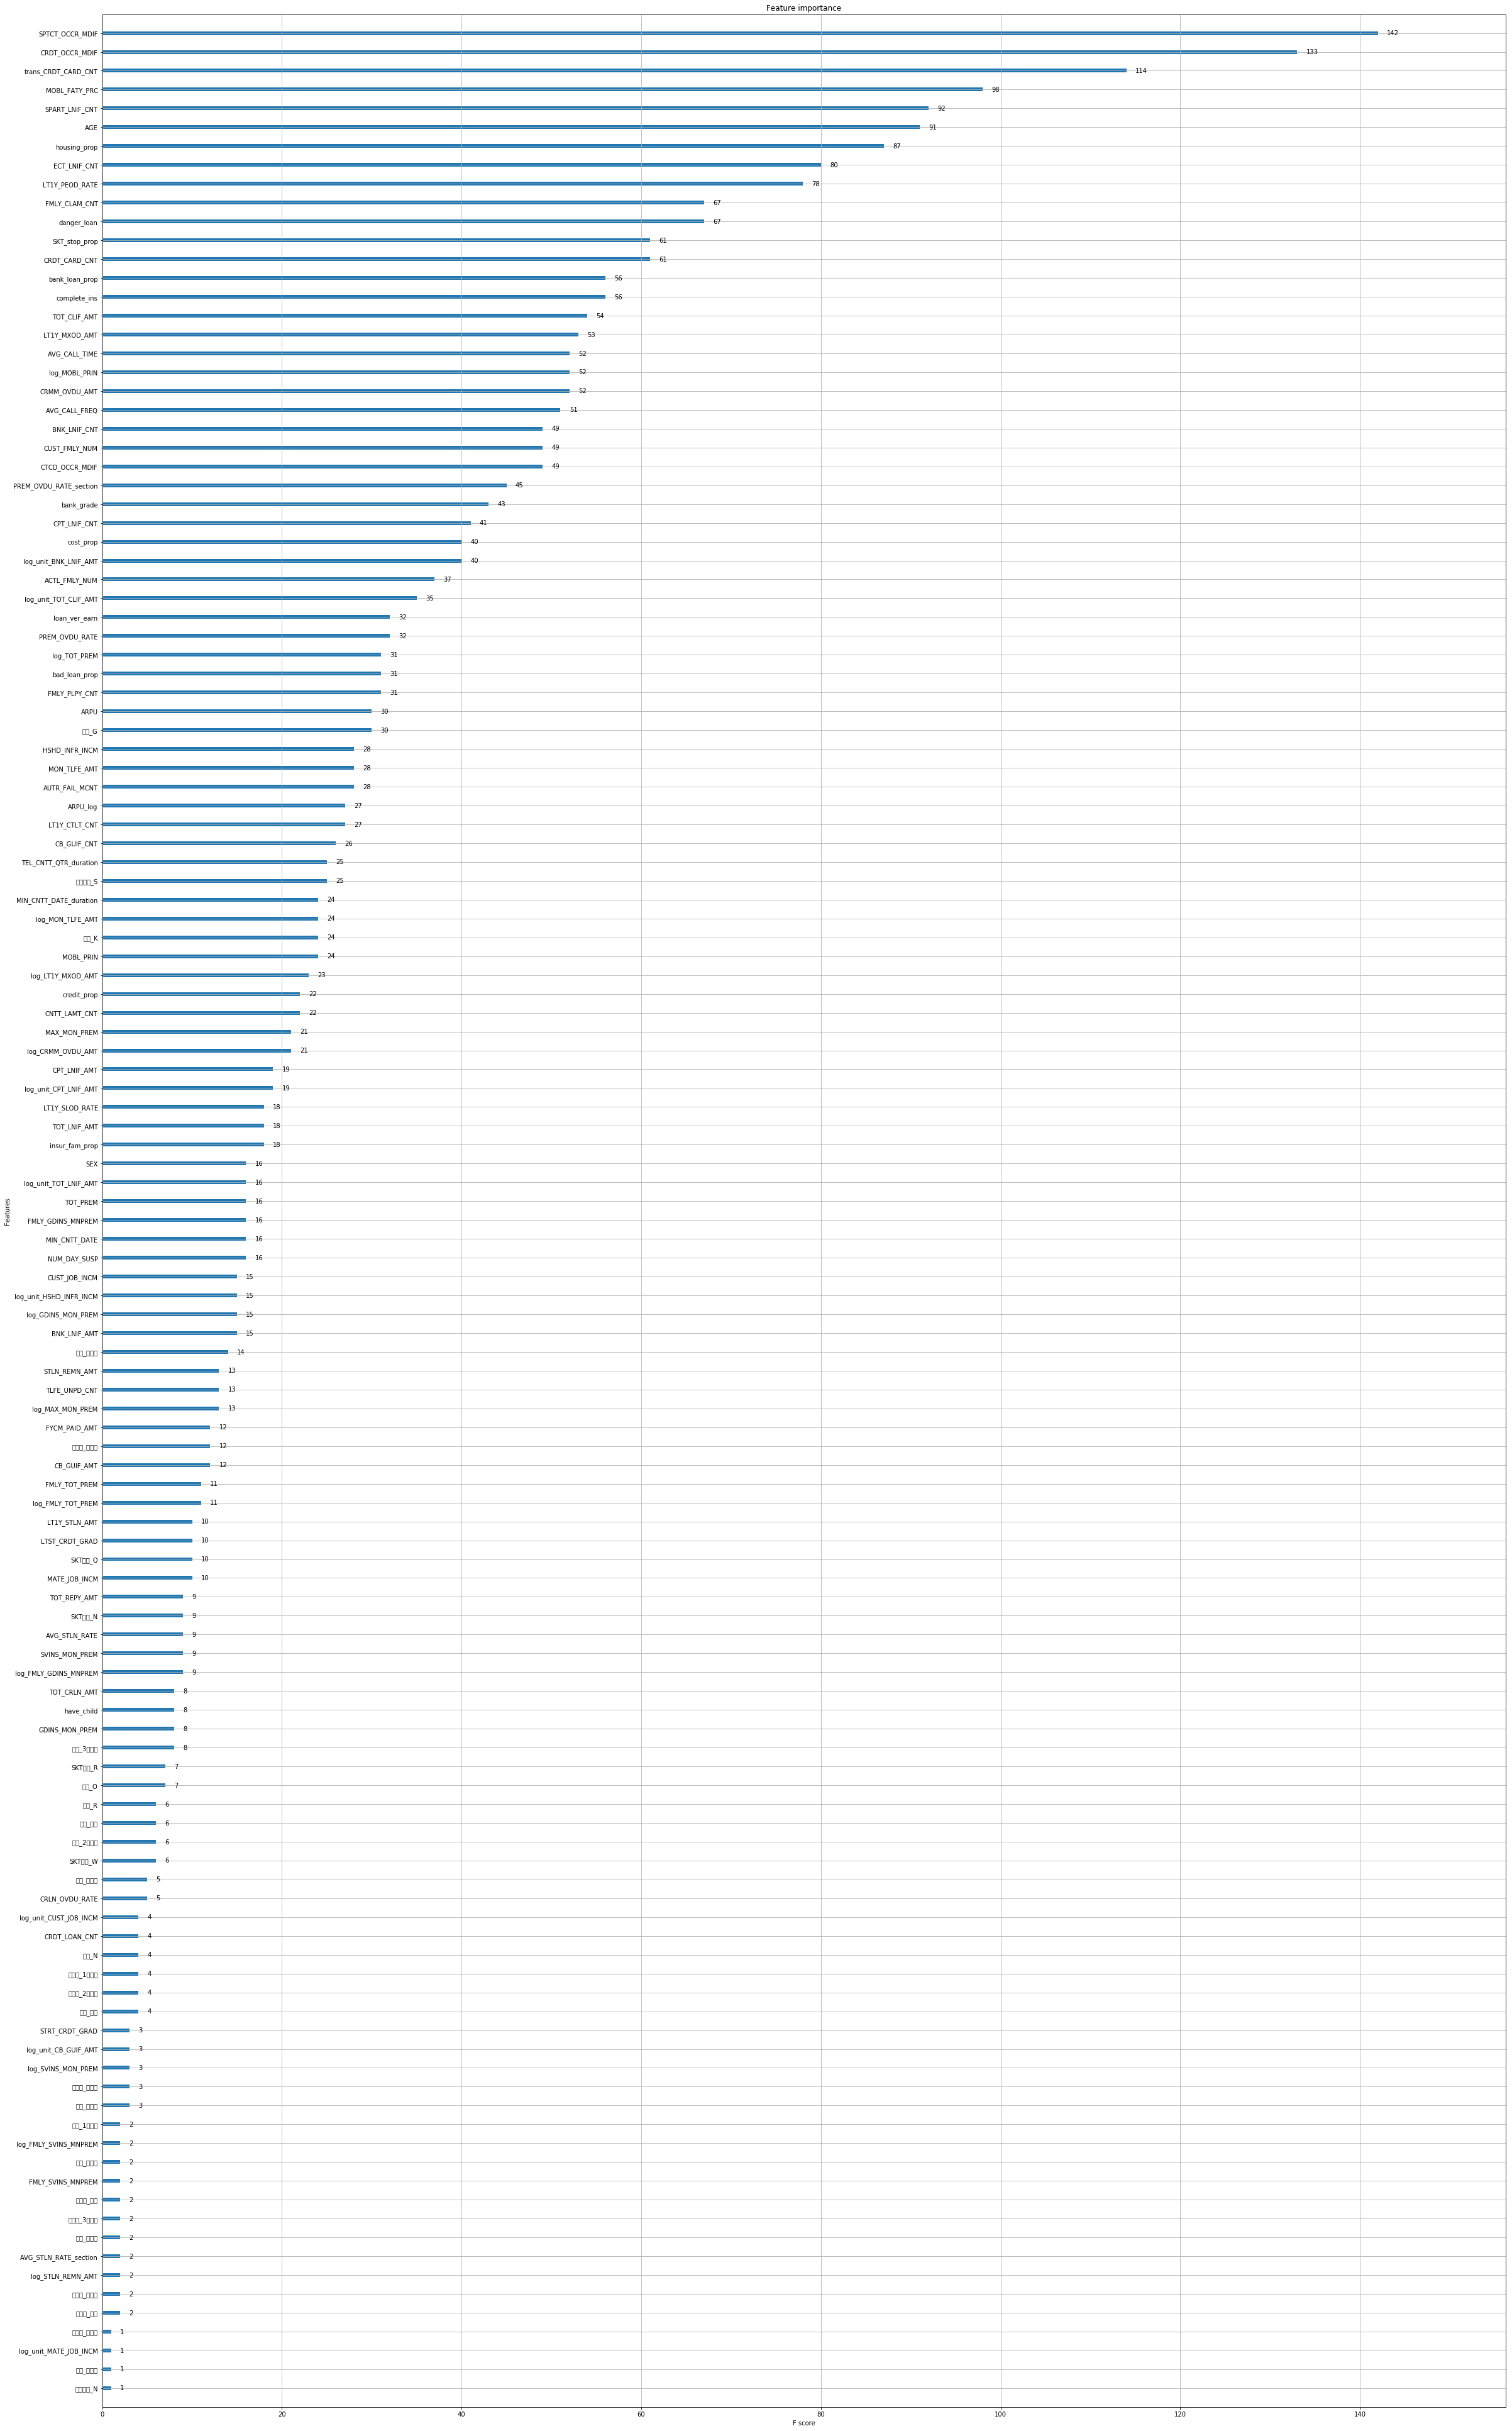

In [70]:
fig, ax = plt.subplots(figsize=(40, 70))
xgb.plot_importance(xgbr, ax=ax)
plt.show()

# 군집화 적용 전 Random Forest


In [78]:
%time

forest = random_forest_once(X_resampled, y_resampled.TARGET,500)


CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.81 µs
Random Forest
Classification Report
             precision    recall  f1-score   support

          0       0.98      0.99      0.98     23923
          1       0.99      0.98      0.98     24050

avg / total       0.98      0.98      0.98     47973

F1 Score list: [ 0.98299071  0.98317214  0.98196267  0.98213013  0.98264282]
 Mean F1 Score: 0.982579695466723


# 군집화 적용 후 Light gbm

In [82]:
param_grid = [{'n_estimators': [100, 500, 1000],
         'learning_rate': [0.1, 0.05, 0.01]}]

In [87]:
# cluster 0 
      
%time 
grid_search_light0, X_val, y_val = lightgbm(X_0, y_0,\
                                                   param_grid )
test_score("Lightgbm", grid_search_light0, X_val, y_val)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs
모델 : Lightgbm
최적 매개변수 : {'learning_rate': 0.1, 'n_estimators': 500}
교차검증 결과 분석
   mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       1.695964         0.064183         0.983490          0.995812   
1       4.907768         0.149363         0.983799          1.000000   
2       9.940832         0.315937         0.983717          1.000000   
3       1.917253         0.067520         0.980048          0.986791   
4       6.760681         0.178926         0.983669          1.000000   

  param_learning_rate param_n_estimators  \
0                 0.1                100   
1                 0.1                500   
2                 0.1               1000   
3                0.05                100   
4                0.05                500   

                                         params  rank_test_score  \
0   {'learning_rate': 0.1, 'n_estimators': 100}                5   
1   {'learning_rate

In [88]:
# cluster 1
      
%time 
grid_search_light1, X_val, y_val = lightgbm(X_1, y_1,\
                                                   param_grid )
test_score("Lightgbm", grid_search_light0, X_val, y_val)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs
모델 : Lightgbm
최적 매개변수 : {'learning_rate': 0.1, 'n_estimators': 500}
교차검증 결과 분석
   mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       1.695964         0.064183         0.983490          0.995812   
1       4.907768         0.149363         0.983799          1.000000   
2       9.940832         0.315937         0.983717          1.000000   
3       1.917253         0.067520         0.980048          0.986791   
4       6.760681         0.178926         0.983669          1.000000   

  param_learning_rate param_n_estimators  \
0                 0.1                100   
1                 0.1                500   
2                 0.1               1000   
3                0.05                100   
4                0.05                500   

                                         params  rank_test_score  \
0   {'learning_rate': 0.1, 'n_estimators': 100}                5   
1   {'learning_rate': 0

In [89]:
# cluster 2 
      
%time 
grid_search_light2, X_val, y_val = lightgbm(X_2, y_2,\
                                                   param_grid )
test_score("Lightgbm", grid_search_light0, X_val, y_val)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.81 µs
모델 : Lightgbm
최적 매개변수 : {'learning_rate': 0.1, 'n_estimators': 500}
교차검증 결과 분석
   mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       1.695964         0.064183         0.983490          0.995812   
1       4.907768         0.149363         0.983799          1.000000   
2       9.940832         0.315937         0.983717          1.000000   
3       1.917253         0.067520         0.980048          0.986791   
4       6.760681         0.178926         0.983669          1.000000   

  param_learning_rate param_n_estimators  \
0                 0.1                100   
1                 0.1                500   
2                 0.1               1000   
3                0.05                100   
4                0.05                500   

                                         params  rank_test_score  \
0   {'learning_rate': 0.1, 'n_estimators': 100}                5   
1   {'learning_rate': 0

In [90]:

# cluster 3 
      
%time 
grid_search_light3, X_val, y_val = lightgbm(X_3, y_3,\
                                                   param_grid )
test_score("Lightgbm", grid_search_light0, X_val, y_val)


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.91 µs
모델 : Lightgbm
최적 매개변수 : {'learning_rate': 0.1, 'n_estimators': 500}
교차검증 결과 분석
   mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       1.695964         0.064183         0.983490          0.995812   
1       4.907768         0.149363         0.983799          1.000000   
2       9.940832         0.315937         0.983717          1.000000   
3       1.917253         0.067520         0.980048          0.986791   
4       6.760681         0.178926         0.983669          1.000000   

  param_learning_rate param_n_estimators  \
0                 0.1                100   
1                 0.1                500   
2                 0.1               1000   
3                0.05                100   
4                0.05                500   

                                         params  rank_test_score  \
0   {'learning_rate': 0.1, 'n_estimators': 100}                5   
1   {'learning_rate': 0

# 군집화 적용 전 lightgbm
* 군집화를 한 것이 훨씬 점수가 높음을 알 수 있다

In [98]:
%time

lightmodel = lightgbm_once(X_resampled, y_resampled.TARGET, 0.1, 500 )


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.01 µs
LightGBM
Classification Report
             precision    recall  f1-score   support

          0       0.97      0.99      0.98     23923
          1       0.99      0.97      0.98     24050

avg / total       0.98      0.98      0.98     47973

F1 Score list: [ 0.98152674  0.98070647  0.97997105  0.97970367  0.97912522]
 Mean F1 Score: 0.9802066297790966
